# Just a Practice Notebook for Random Data Science Stuff

In [6]:
import torch

In [7]:
class Metrics():
    def euclidean_distance(self, X, Y):
        Z = X - Y
        return torch.sqrt(torch.dot(Z, Z))
         
    def manhattan_distance(self, X, Y):
        return torch.sum(torch.abs(X - Y))

    def cosine_similarity(self, X, Y):
        return torch.dot(X, Y) / (self.two_norm(X) * self.two_norm(Y))
        # or even simpler with: 
        # return torch.cosine_similarity(X, Y, dim=0) 

    def jaccard_similarity(self, X, Y):                
        XandY = set([e for e in X + Y])
        XorY = set([e for e in X if e in Y])
        return len(XorY) / len(XandY)
        
    def two_norm(self, X):
        return sum(xi ** 2 for xi in X) ** 0.5

X = torch.tensor([1, 3, 4, 5], dtype=torch.float32)
Y = torch.tensor([7, 6, 3, 1], dtype=torch.float32)

print("X={}".format(X))
print("Y={}".format(Y))

metrics = Metrics()
print("2-Norm of X: {}".format(metrics.two_norm(X)))
print("2-Norm of Y: {}".format(metrics.two_norm(Y)))
print()
print("Euclidean Distance: {}".format(metrics.euclidean_distance(X,Y)))
print("Manhattan Distance: {}".format(metrics.manhattan_distance(X,Y)))
print("Cosine Similarity: {}".format(metrics.cosine_similarity(X,Y)))
print("Jaccard Similarity: {}".format(metrics.jaccard_similarity(X,Y)))

X=tensor([1., 3., 4., 5.])
Y=tensor([7., 6., 3., 1.])
2-Norm of X: 7.141428470611572
2-Norm of Y: 9.746794700622559

Euclidean Distance: 7.874007701873779
Manhattan Distance: 14.0
Cosine Similarity: 0.6033958792686462
Jaccard Similarity: 0.5


## Implementing KNN search and predict a binary label using KNN search

In [8]:
from heapq import heappush, heappop

class KnnSearch:
    
    def predict_label(self, samples, query_vector, k, label_key="label"):
        knn = self.find_k_nearest_neighbors(samples, query_vector, k)
        # Compute the average (binary) label of the KNN 
        return round(sum(samples[entry][label_key] for entry in knn) / len(knn))
    
    def find_k_nearest_neighbors(self, samples, query_vector, k):
        # O(n log k) time and O(k) space, n = len(samples)
        k_nearest = []
        for sample_id, sample in samples.items():
            d = self.l2_norm(sample['vector'], query_vector)
            e = [-d, sample_id]
            heappush(k_nearest, e)
            while len(k_nearest) > k:
                heappop(k_nearest)
        result = []
        while k_nearest:
            _, sample = heappop(k_nearest)
            result.append(sample)
        result.reverse()
        return result
    
    def l2_norm(self, vector_u , vector_v):
        return torch.linalg.norm(vector_u - vector_v).item() # use .item() to get the value out of a 1-element + 1d-tensor
    
knn = KnnSearch()
samples = {
    'id-1': {'vector': torch.tensor([1, 3, 4, 5], dtype=torch.float32), 'label': 1},
    'id-2': {'vector': torch.tensor([7, 6, 3, 1], dtype=torch.float32), 'label': 0},
    'id-3': {'vector': torch.tensor([2, 3, 4, 5], dtype=torch.float32), 'label': 1},
    'id-4': {'vector': torch.tensor([1, 3, 9, 5], dtype=torch.float32), 'label': 0},
    'id-5': {'vector': torch.tensor([7, 2, 3, 1], dtype=torch.float32), 'label': 1},
    'id-6': {'vector': torch.tensor([2, 3, 4, 8], dtype=torch.float32), 'label': 0},    
}

# And lets do some basic testing
k, query = 3, torch.tensor([1, 3, 4, 5], dtype=torch.float32)
print("The {}-NN of {} are:".format(k, query), knn.find_k_nearest_neighbors(samples, query, k))

k, query = 1, samples['id-1']['vector']
print("The {}-NN of {} is:".format(k, query), knn.find_k_nearest_neighbors(samples, query, k))

k, query = 2, samples['id-2']['vector']
print("The {}-NN of {} are:".format(k, query), knn.find_k_nearest_neighbors(samples, query, k))

print()

k, query = 1, samples['id-1']['vector']
print("The predicted label of {} (with k={}) is:".format(query, k), knn.predict_label(samples, query, k))

k, query = 4, samples['id-1']['vector']
print("The predicted label of {} (with k={}) is:".format(query, k), knn.predict_label(samples, query, k))

k, query = 1, samples['id-2']['vector']
print("The predicted label of {} (with k={}) is:".format(query, k), knn.predict_label(samples, query, k))

k, query = 4, samples['id-2']['vector']
print("The predicted label of {} (with k={}) is:".format(query, k), knn.predict_label(samples, query, k))


The 3-NN of tensor([1., 3., 4., 5.]) are: ['id-1', 'id-3', 'id-6']
The 1-NN of tensor([1., 3., 4., 5.]) is: ['id-1']
The 2-NN of tensor([7., 6., 3., 1.]) are: ['id-2', 'id-5']

The predicted label of tensor([1., 3., 4., 5.]) (with k=1) is: 1
The predicted label of tensor([1., 3., 4., 5.]) (with k=4) is: 0
The predicted label of tensor([7., 6., 3., 1.]) (with k=1) is: 0
The predicted label of tensor([7., 6., 3., 1.]) (with k=4) is: 1


## Implementing KMeans Clustering

In [9]:
class KMeans:
    
    def assign_clusters(self, datapoints, centroids):
        # Compute the distance between each datapoint and each centroid
        distances = torch.cdist(datapoints, centroids) # O(n * k * d)
        # Assign each datapoint to the cluster with the nearest centroid
        return torch.argmin(distances, dim=1)
    
    def find_centroids(self, datapoints, num_clusters, max_iterations=100):
        features = datapoints.shape[1]    
        # Initialize the centroids randomly
        centroids = torch.randn(num_clusters, features)  
        for num_iterations in range(max_iterations):
            # Assign each datapoint to the nearest cluster
            clusters = self.assign_clusters(datapoints, centroids)
            # Update the cluster centers
            new_centroids = torch.zeros_like(centroids)
            for i in range(num_clusters):
                cluster_points = datapoints[clusters == i]
                if len(cluster_points) > 0:
                    new_centroids[i] = cluster_points.mean(dim=0)
            # Check if the cluster centers have converged
            if torch.all(new_centroids == centroids):
                break
            centroids = new_centroids
        return centroids, num_iterations

# Lets test the KMeans implementation with a simple dataset        
dataset = torch.tensor([
    [1, 3], [7, 6], [2, 3], [1, 9], [7, 2], [2, 4], 
    [1, 4], [7, 5], [2, 2], [1, 8], [7, 1], [2, 5]
], dtype=torch.float32)

kmeans = KMeans()
for k in range(1, 4):
    centroids = kmeans.find_centroids(dataset, num_clusters=k)
    print("Centroids for k={}: {}".format(k, centroids))

Centroids for k=1: (tensor([[3.3333, 4.3333]]), 1)
Centroids for k=2: (tensor([[7.0000, 3.5000],
        [1.5000, 4.7500]]), 2)
Centroids for k=3: (tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [3.3333, 4.3333]]), 1)


Lets generate some random data to test the KMeans implementation. For that we pick three random points around which we will generate clustered datapoints. We hope that our KMeans implementation will be able to find these three clusters later.

Found centroids after 9 iterations:

tensor([[-0.1609,  1.3716],
        [-1.1851, -0.3469],
        [-1.0667,  0.5884]])


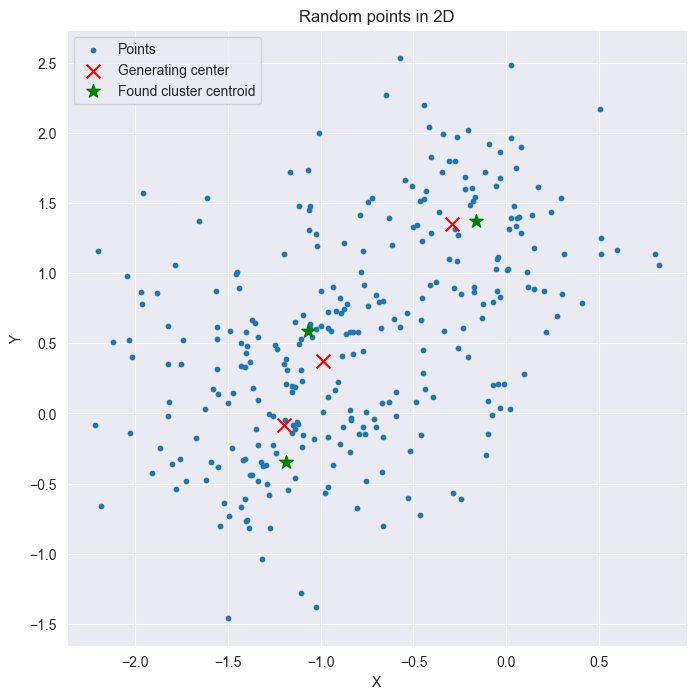

In [13]:
import torch
import matplotlib.pyplot as plt

# Geneating the dataset
num_clusters = 3
num_points_per_cluster = 100
cluster_centers = torch.randn(num_clusters, 2) * 2
X = torch.zeros(num_clusters * num_points_per_cluster, 2)
for i in range(num_clusters):
    cluster_points = torch.randn(num_points_per_cluster, 2) * 0.5 + cluster_centers[i]
    X[i*num_points_per_cluster:(i+1)*num_points_per_cluster] = cluster_points

# Finding the cluster centers using KMeans
kmeans = KMeans()
max_iterations=10
found_centroids, num_iterations = kmeans.find_centroids(X, num_clusters, max_iterations)
print("Found centroids after {} iterations:\n\n{}".format(num_iterations, found_centroids))

# Visualize the generated clusters
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=100, marker='x', c='r')
plt.scatter(found_centroids[:, 0], found_centroids[:, 1], s=100, marker='*', c='g')
plt.title("Random points in 2D")
plt.legend(["Points", "Generating center", "Found cluster centroid"])
plt.xlabel("X")
plt.ylabel("Y")
plt.show()